# Scanpy/PAGA - Explant

**Notes:**  
- DiffusionMap computed in scater/destiny  
- Seurat object (in_silico_clusters) __without__ outlying C9 cluster (based on diffusion components)
***

- Goal: import pre-processed data from Seurat to Scanpy and run PAGA
- Reference: https://scanpy-tutorials.readthedocs.io/en/latest/paga-paul15.html
- Convert from Seurat: https://github.com/LuckyMD/Code_snippets/blob/master/Seurat_to_anndata.ipynb
***

*Import libraries*

In [1]:
import os
import fa2
import sys
import loompy
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
import scanpy as sc
sc.logging.print_versions()

/Users/rmevel/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


scanpy==1.4.6 anndata==0.7.1 umap==0.4.1 numpy==1.18.1 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.1 statsmodels==0.11.1 python-igraph==0.8.0


*Set parameters*

In [2]:
# Change directory
os.getcwd()
os.chdir('/Users/rmevel/jupyter/scanpy_mevel_et_al/sc_explant_dataset/Explant_final/')

In [3]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=100, frameon=False, figsize=(4,4))
results_file = './write/Mevel_et_al_sc_explant.h5ad'

scanpy==1.4.6 anndata==0.7.1 umap==0.4.1 numpy==1.18.1 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.1 statsmodels==0.11.1 python-igraph==0.8.0


## Load data

We use the loom file generated using `as.loom` from Seurat. Use scVelo to import seurat object as `read_loom` is failing in scanpy.  
__Important:__ Make sure the file is not used somewhere else (R or other notebook) as this will cause it to fail opening.

In [4]:
# scanpy read function
adata = sc.read_loom("/Users/rmevel/r/sc_mevel_et_al/sc_explant_dataset/loom/mevel_et_al_sc_explant_sce_final.loom")

In [5]:
# Print content
adata

AnnData object with n_obs × n_vars = 3937 × 31053 
    obs: 'Cell', 'ClusterID', 'ClusterName', 'Phase', 'in_silico_clusters', 'nCount_RNA', 'nFeature_RNA', 'percent_mt', 'sample', 'seurat_clusters'
    var: 'Selected', 'vst_mean', 'vst_variable', 'vst_variance', 'vst_variance_expected', 'vst_variance_standardized'
    obsm: 'DiffusionMap_cell_embeddings', 'pca_cell_embeddings', 'umap_cell_embeddings'
    varm: 'pca_feature_loadings'
    layers: 'norm_data', 'scale_data'

Let us work with a higher precision than the default ‘float32’ to ensure exactly the same results across different computational platforms.

In [6]:
adata.X = adata.X.astype('float64')  # this is not required and results will be comparable without it

Check presence of dimensionally reduced data, and plot umap

In [7]:
adata.obsm

AxisArrays with keys: DiffusionMap_cell_embeddings, pca_cell_embeddings, umap_cell_embeddings

Define sample colors

In [8]:
adata.uns['sample_colors'] = ["#DC2B19", "#F7A400", "#72ABF8", "#434CA7"]
adata.uns['in_silico_clusters_colors'] = ["#F09900", "#F1BA88", "#D63A69", "#9DDED6", "#8DD593", "#428654", "#B2B8E0", "#4A6FE3", "#1037AA"]

In [9]:
adata.uns

OrderedDict([('sample_colors', ['#DC2B19', '#F7A400', '#72ABF8', '#434CA7']),
             ('in_silico_clusters_colors',
              ['#F09900',
               '#F1BA88',
               '#D63A69',
               '#9DDED6',
               '#8DD593',
               '#428654',
               '#B2B8E0',
               '#4A6FE3',
               '#1037AA'])])

Plot previously computed embeddings

... storing 'ClusterName' as categorical
... storing 'Phase' as categorical
... storing 'in_silico_clusters' as categorical
... storing 'sample' as categorical
... storing 'seurat_clusters' as categorical


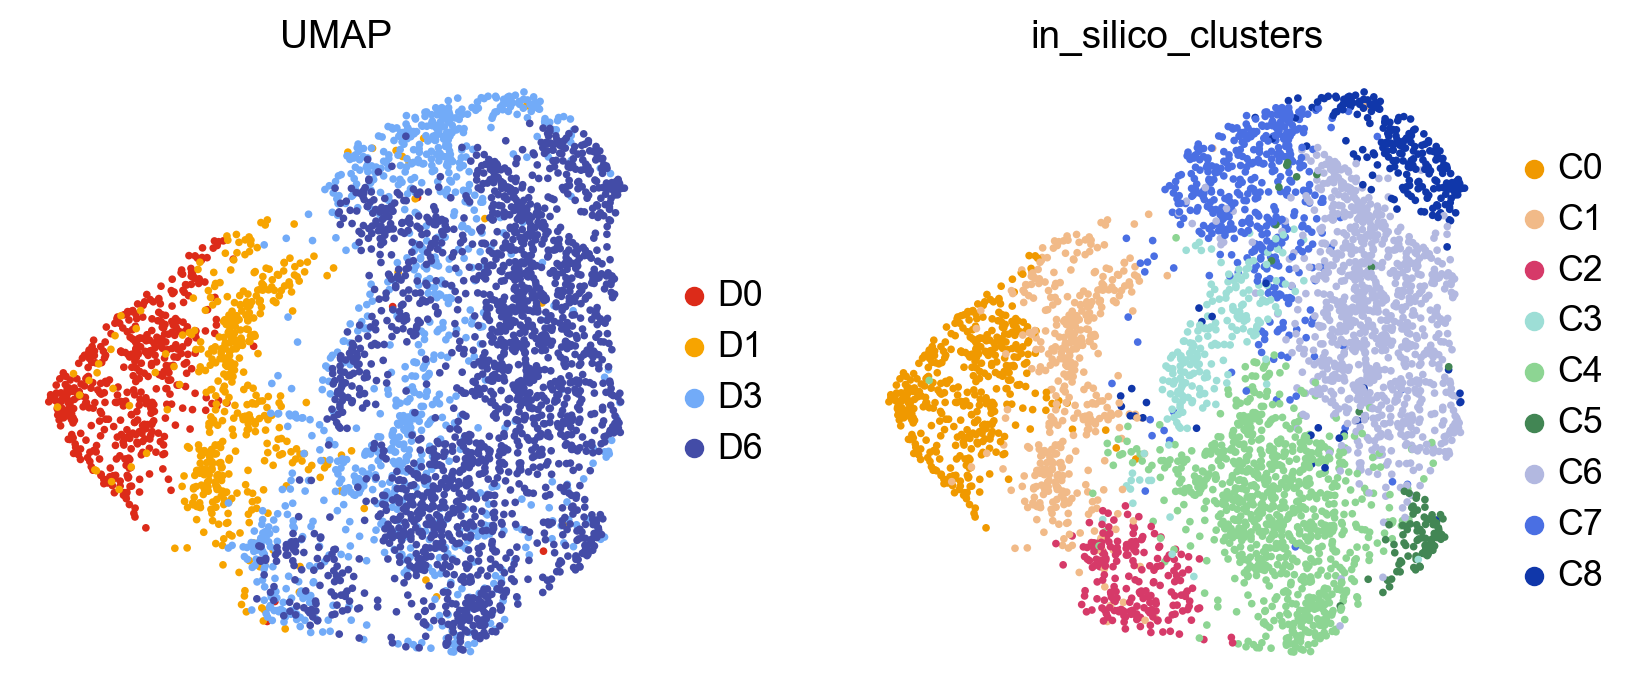

In [10]:
sc.pl.embedding(adata, basis='umap_cell_embeddings', color=['sample', 'in_silico_clusters'], title="UMAP")

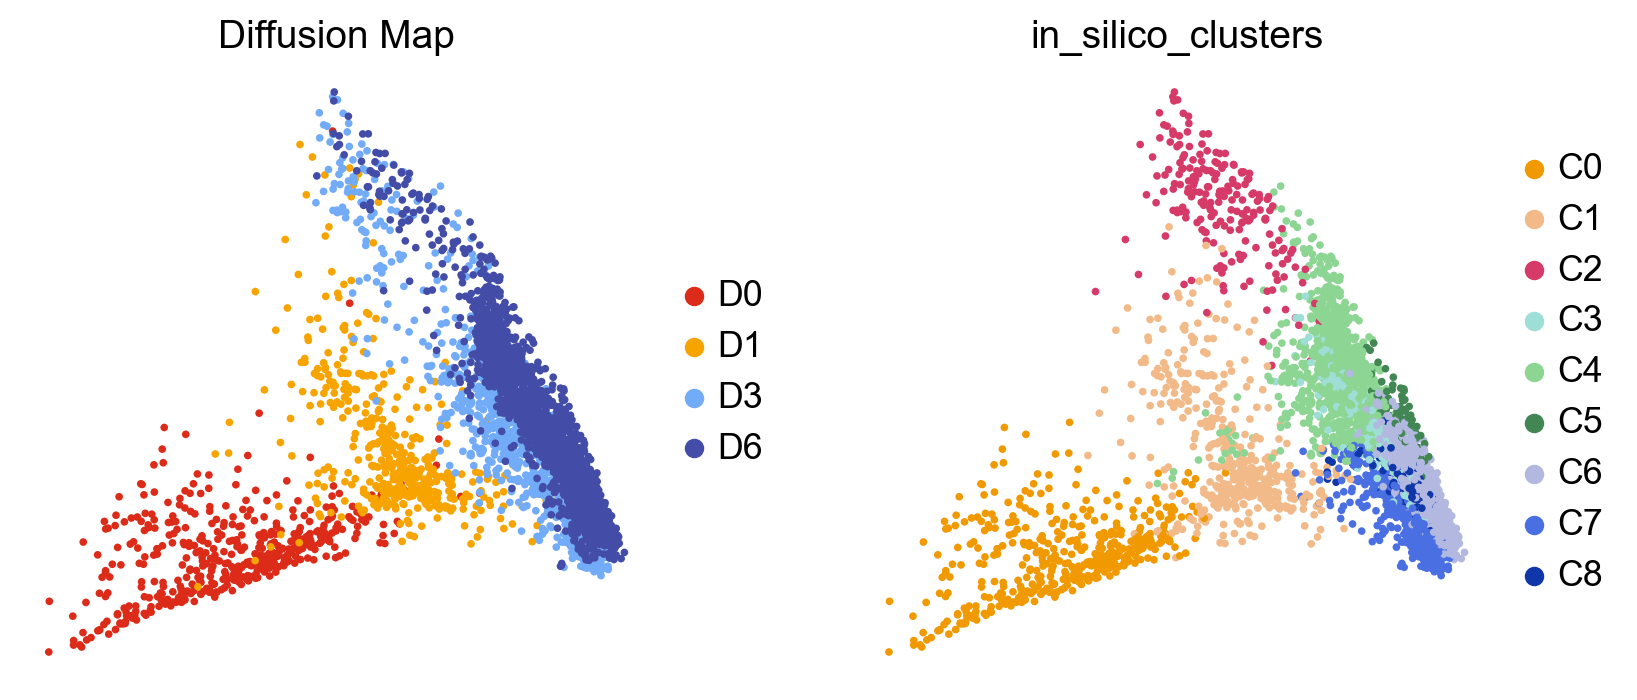

In [11]:
sc.pl.embedding(adata, basis='DiffusionMap_cell_embeddings', color=['sample', 'in_silico_clusters'], title="Diffusion Map")

Log transform the data for plotting

In [12]:
sc.pp.log1p(adata)

In [13]:
adata

AnnData object with n_obs × n_vars = 3937 × 31053 
    obs: 'Cell', 'ClusterID', 'ClusterName', 'Phase', 'in_silico_clusters', 'nCount_RNA', 'nFeature_RNA', 'percent_mt', 'sample', 'seurat_clusters'
    var: 'Selected', 'vst_mean', 'vst_variable', 'vst_variance', 'vst_variance_expected', 'vst_variance_standardized'
    uns: 'sample_colors', 'in_silico_clusters_colors', 'log1p'
    obsm: 'DiffusionMap_cell_embeddings', 'pca_cell_embeddings', 'umap_cell_embeddings'
    varm: 'pca_feature_loadings'
    layers: 'norm_data', 'scale_data'

### Add DiffusionMap components from seurat
We use a csv to import the components because Seurat `as.loom` function only saved the 2 first DCs  
We can double check number of dimensions in the imported from seurat diffusion map:

In [14]:
adata.obsm['DiffusionMap_cell_embeddings'].ndim

2

In [15]:
dm20 = pd.read_csv("/Users/rmevel/r/sc_mevel_et_al/sc_explant_dataset/r_save/diffmap20_final.csv", index_col=0)
dm10 = dm20[dm20.columns[0:10]]
dm5 = dm20[dm20.columns[0:5]]

In [16]:
adata.obsm['seu_diffmap20'] = dm20.values
adata.obsm['seu_diffmap10'] = dm10.values
adata.obsm['seu_diffmap5'] = dm5.values

In [17]:
adata.obsm

AxisArrays with keys: DiffusionMap_cell_embeddings, pca_cell_embeddings, umap_cell_embeddings, seu_diffmap20, seu_diffmap10, seu_diffmap5

### Save a secondary object for later use if required

In [18]:
import copy
sdata = copy.deepcopy(adata)

In [19]:
### Use this if need to copy object back
adata = copy.deepcopy(sdata)

## B. PAGA/FA - 10 diffusion components / CHOICE

In [20]:
### Use this if need to copy object back
adata = copy.deepcopy(sdata)

Use the first 5 diffusion map components calculated before in Seurat to denoise the graph.

In [21]:
sc.pp.neighbors(adata, n_neighbors=20, use_rep='seu_diffmap10')

computing neighbors
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:05)


Compute PAGA using previously computed clusters

In [22]:
sc.tl.paga(adata, groups='in_silico_clusters')

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)


--> added 'pos', the PAGA positions (adata.uns['paga'])


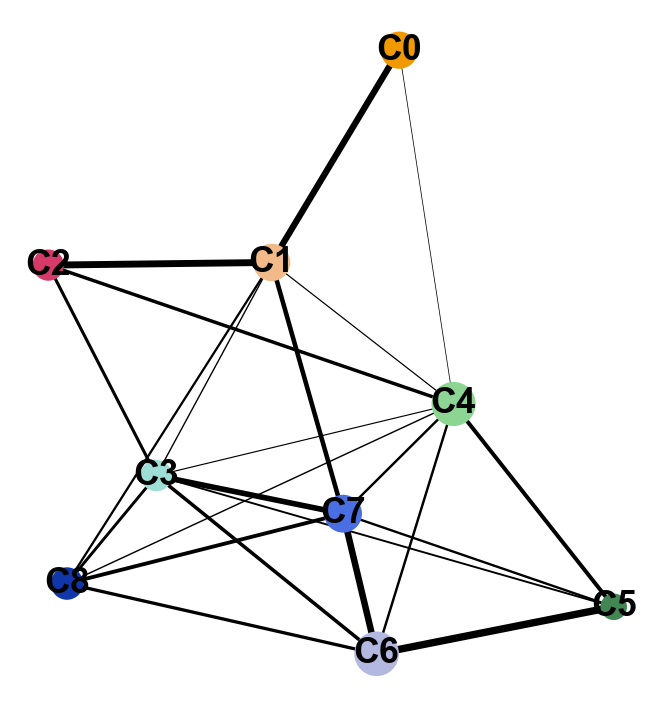

In [23]:
sc.pl.paga(adata, color=['in_silico_clusters'])

--> added 'pos', the PAGA positions (adata.uns['paga'])


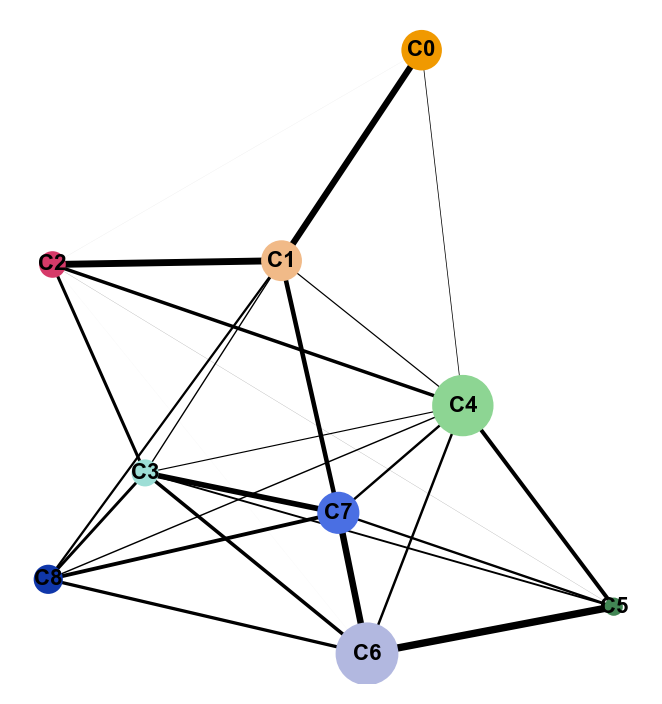

In [24]:
# Make figures
rcParams['figure.figsize'] = 4,4
sc.pl.paga(adata, plot=True, color=['in_silico_clusters'], 
           node_size_scale=1.2, node_size_power=1.2, edge_width_scale=1,
           fontsize=8, save=False, threshold=0.0)

In [25]:
pos1 = adata.uns['paga']['pos']
np.savetxt('pos1.csv', pos1, delimiter=',')
pos1 = np.loadtxt('pos1.csv', delimiter=',')

In [26]:
sc.tl.draw_graph(adata, init_pos='paga')

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:24)


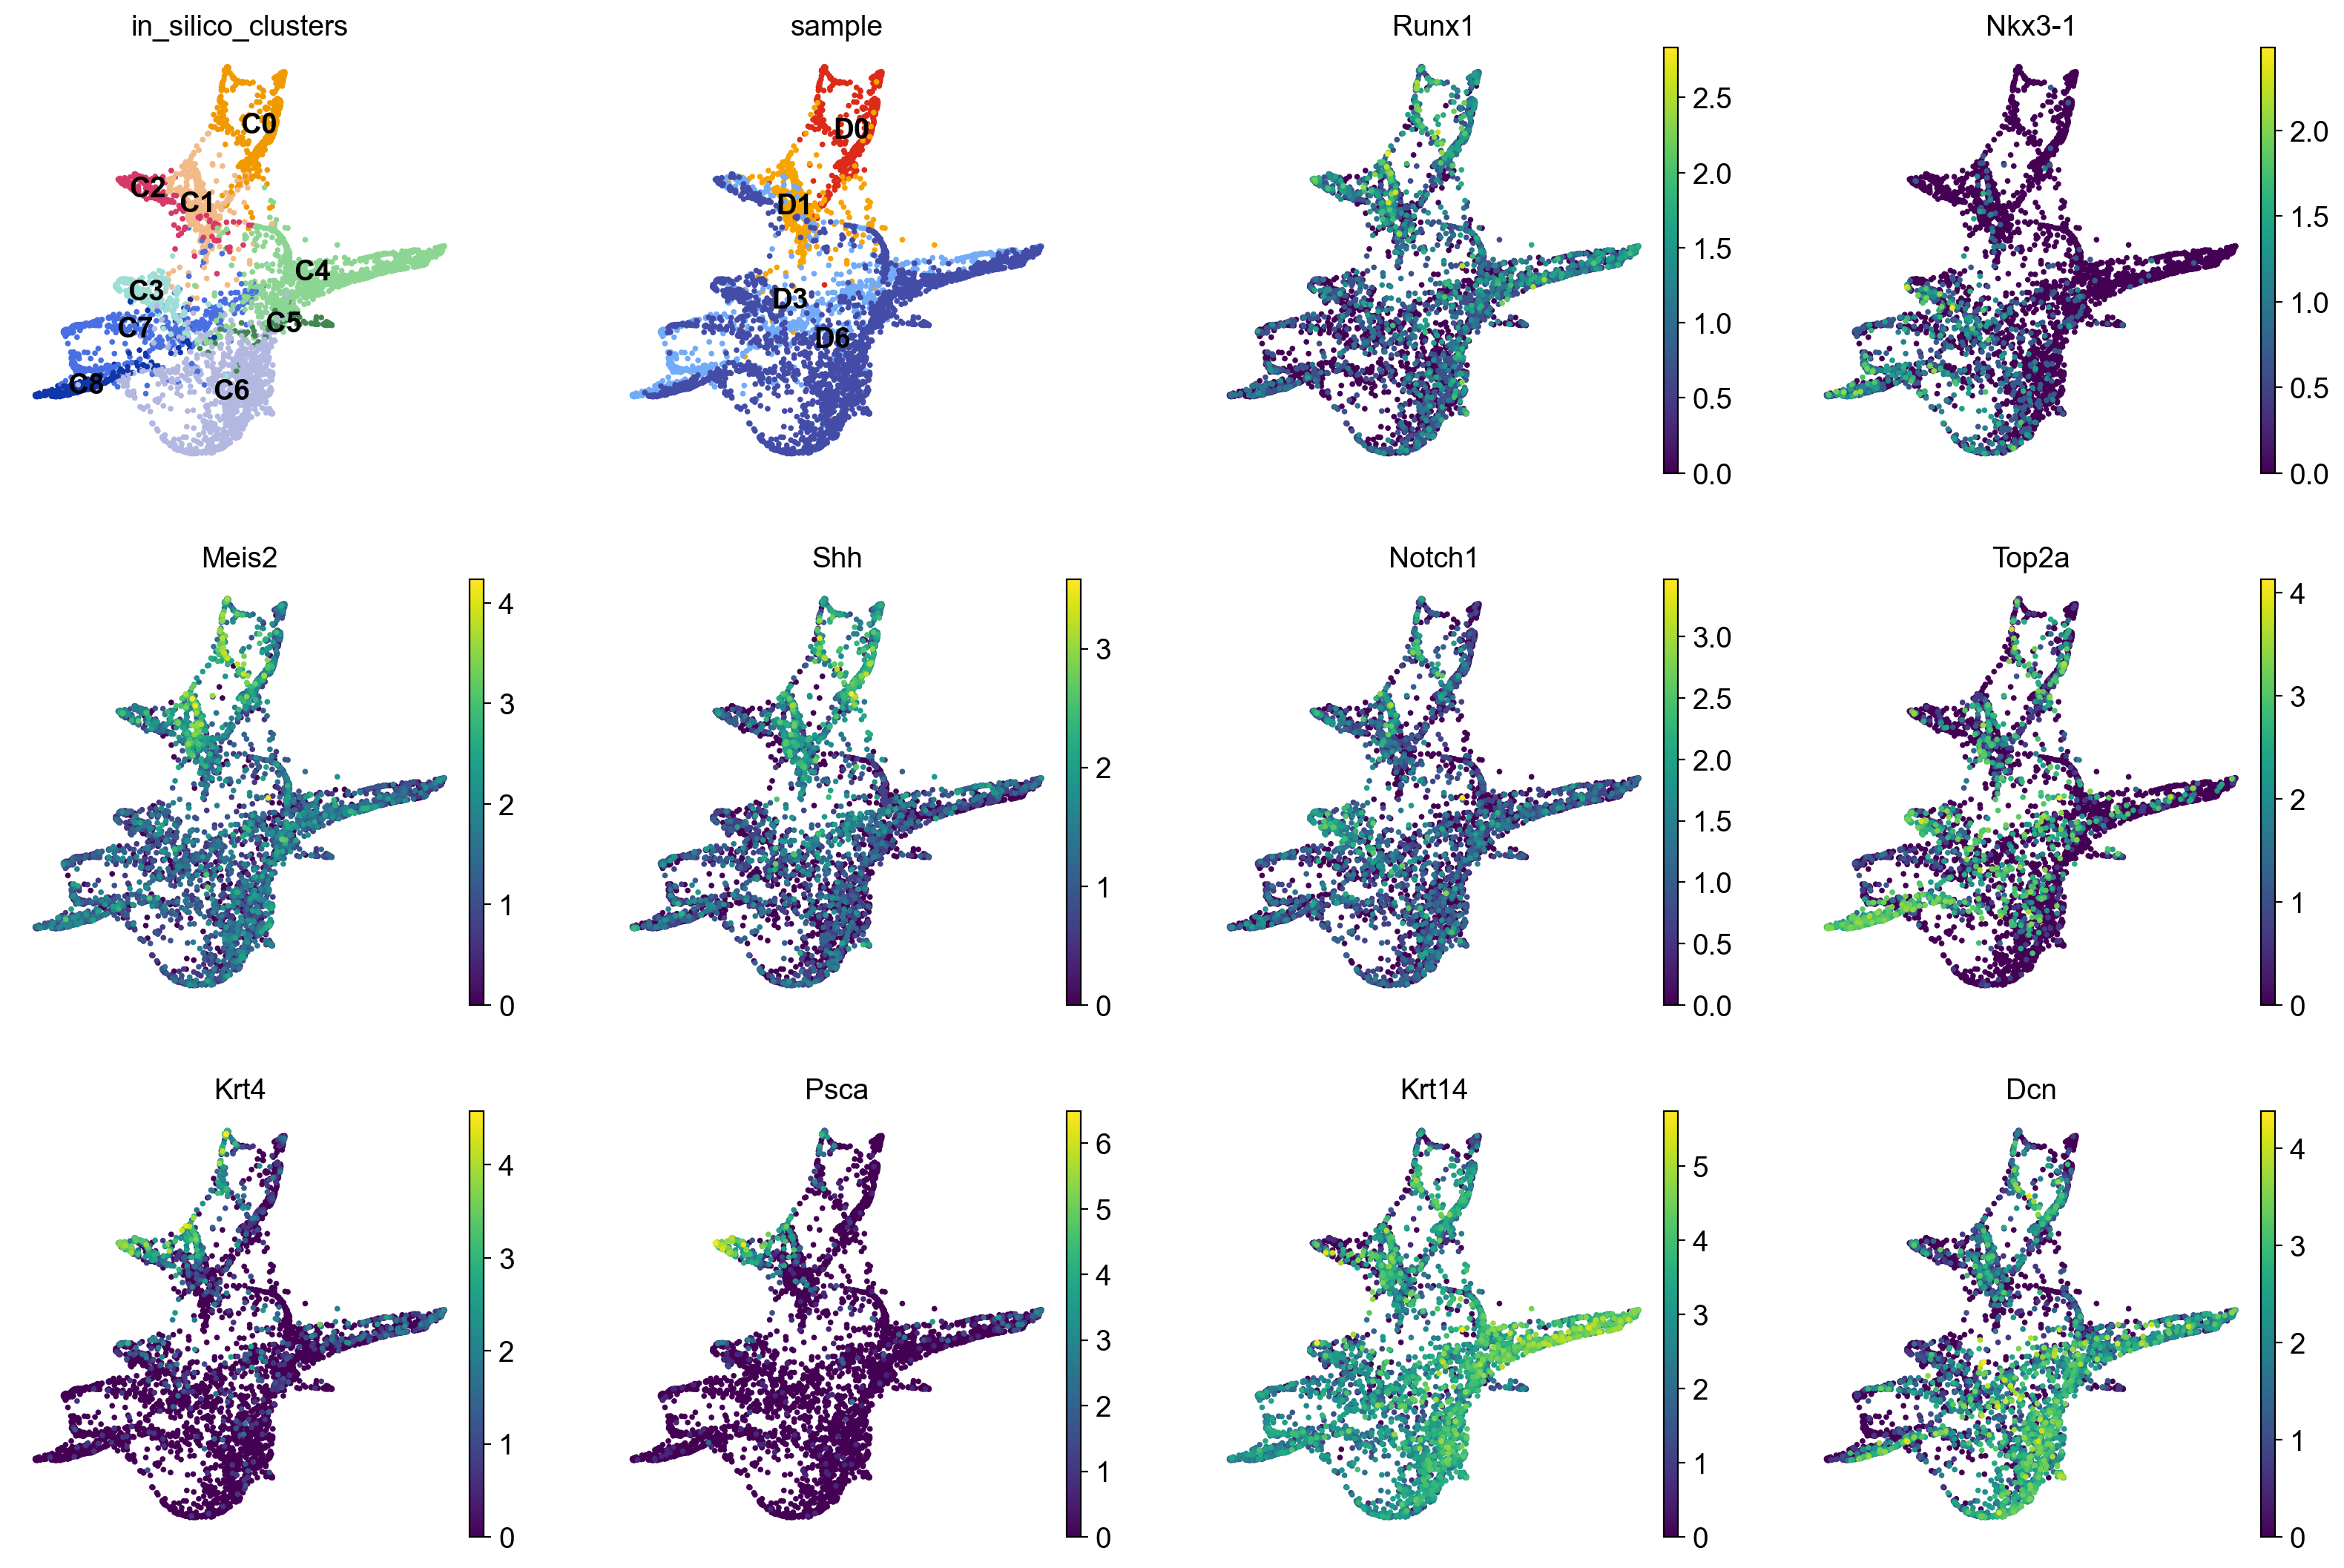

In [27]:
sc.pl.draw_graph(adata, 
                 color=['in_silico_clusters', 'sample', 'Runx1', 'Nkx3-1', 'Meis2', 'Shh', 'Notch1', 'Top2a', 'Krt4', 'Psca', 'Krt14', 'Dcn'], 
                 legend_loc='on data')

--> added 'pos', the PAGA positions (adata.uns['paga'])


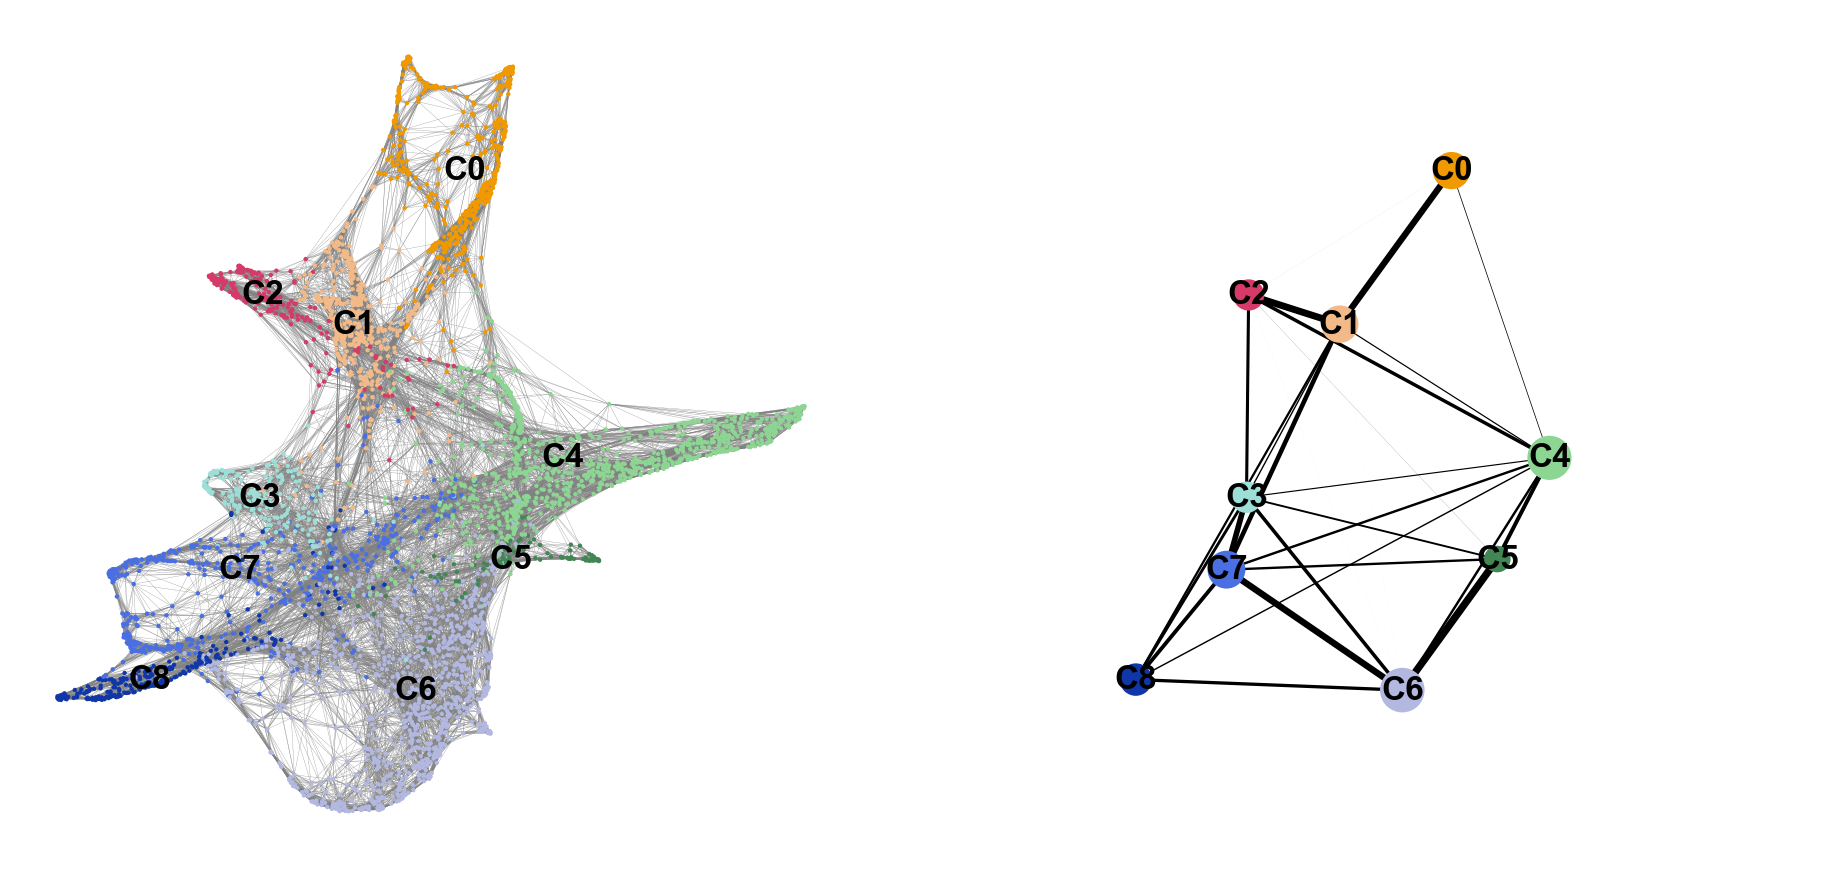

In [28]:
rcParams['figure.figsize'] = 5,5
sc.pl.paga_compare(
    adata, threshold=0.0, title='', right_margin=0.2, size=10, edge_width_scale=1,
    legend_fontsize=12, fontsize=12, frameon=False, edges=True, save=False, add_pos=True)

**Stop here**  
- End plotting here, as the last version of the plot gets saved in** `adata.uns['paga']['pos']`.   
- What we export after this, will consist in the PAGA of the Force Atlas layout, and the Force Atlas layout itself.

In [29]:
# Check data is present
adata.uns['paga']

{'connectivities': <9x9 sparse matrix of type '<class 'numpy.float64'>'
 	with 54 stored elements in Compressed Sparse Row format>,
 'connectivities_tree': <9x9 sparse matrix of type '<class 'numpy.float64'>'
 	with 8 stored elements in Compressed Sparse Row format>,
 'groups': 'in_silico_clusters',
 'pos': array([[ 1868.53095764, 14425.87121341],
        [-1673.12738066,  7571.18475437],
        [-4563.27043128,  8873.10688412],
        [-4630.90135792,  -158.15742909],
        [ 4971.92500354,  1601.5280628 ],
        [ 3320.39559066, -2918.2338292 ],
        [  307.44209368, -8769.82594029],
        [-5266.84259784, -3392.24459826],
        [-8138.84414924, -8299.80710506]])}

### Export

Follow script available here: https://lazappi.github.io/phd-thesis-analysis/05-paga.html

In [30]:
import os
import json

In [31]:
out_dir = 'output/paga_diffmap10'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

def con2edges(con, names=None, sparse=True):
    print('Converting connectivity matrix to edges...')
    n = con.shape[0]
    edges = pd.DataFrame(columns=['From', 'To', 'Connectivity'])

    for i in range(n):
        for j in range(i + 1, n):
            if names is not None:
                fr = names[i]
                to = names[j]
            else:
                fr = str(i)
                to = str(j)

            connectivity = con[i, j]
            if sparse and connectivity == 0:
                continue

            entry = {'From' : fr, 'To' : to,
                     'Connectivity' : con[i, j]}
            edges = edges.append(entry, ignore_index=True)

    return edges

print('Outputting cluster edges...')
clust_con = adata.uns['paga']['connectivities'].toarray()
clust_edges = con2edges(clust_con)
clust_edges.to_csv(os.path.join(out_dir, 'cluster_edges.csv'),
                   index=False)

print('Outputting cluster tree edges...')
clust_tree_con = adata.uns['paga']['connectivities_tree'].toarray()
clust_tree_edges = con2edges(clust_tree_con)
clust_tree_edges.to_csv(os.path.join(out_dir, 'cluster_tree_edges.csv'),
                        index=False)

print('Outputting cluster embedding...')
clust_embedding = pd.DataFrame(adata.uns['paga']['pos'], columns=['X', 'Y'])
clust_embedding['in_silico_clusters'] = range(clust_embedding.shape[0])
clust_embedding = clust_embedding[['in_silico_clusters', 'X', 'Y']]

clust_embedding.to_csv(os.path.join(out_dir, 'cluster_embedding.csv'),
                       index=False)

print('Outputting cell edges...')
cells = adata.obs['Cell']
cell_con = adata.uns['neighbors']['connectivities']
cell_edges = pd.DataFrame(columns=['From', 'To', 'Connectivity'])
n_rows = len(cell_con.indptr)

for i in range(len(cell_con.indptr) - 1):
    row_ind = cell_con.indices[cell_con.indptr[i]:cell_con.indptr[i + 1]]
    print(f'\r\tRow {i} of {n_rows}', end='')
    for k, j in enumerate(row_ind):
        if j > i:
            con = cell_con.data[cell_con.indptr[i] + k]
            fr = cells[i]
            to = cells[j]
            entry = {'From' : fr, 'To' : to, 'Connectivity' : con}
            cell_edges = cell_edges.append(entry, ignore_index=True)
print('\n')

cell_edges.to_csv(os.path.join(out_dir, 'cell_edges.csv'),
                  index=False)

print('Outputting cell embedding...')
x = adata.obsm['X_draw_graph_fa'][:, 0]
y = adata.obsm['X_draw_graph_fa'][:, 1]
cell_embedding = pd.DataFrame({'Cell' : cells, 'X' : x, 'Y' : y})
cell_embedding.to_csv(os.path.join(out_dir, 'cell_embedding.csv'),
                      index=False)

print('Done!')

Outputting cluster edges...
Converting connectivity matrix to edges...
Outputting cluster tree edges...
Converting connectivity matrix to edges...
Outputting cluster embedding...
Outputting cell edges...
	Row 3936 of 3938

Outputting cell embedding...
Done!


### Pseudotime
Define root and compute pseudotime

In [32]:
adata.uns['iroot'] = np.flatnonzero(adata.obs['in_silico_clusters']  == 'C0')[0]

In [33]:
sc.tl.dpt(adata)

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.99693996 0.9951376  0.99375236 0.9925823  0.9916828
     0.9903985  0.9900524  0.9882578  0.98798573 0.9835687  0.98316854
     0.9818687  0.9786218  0.9764395 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)
computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)


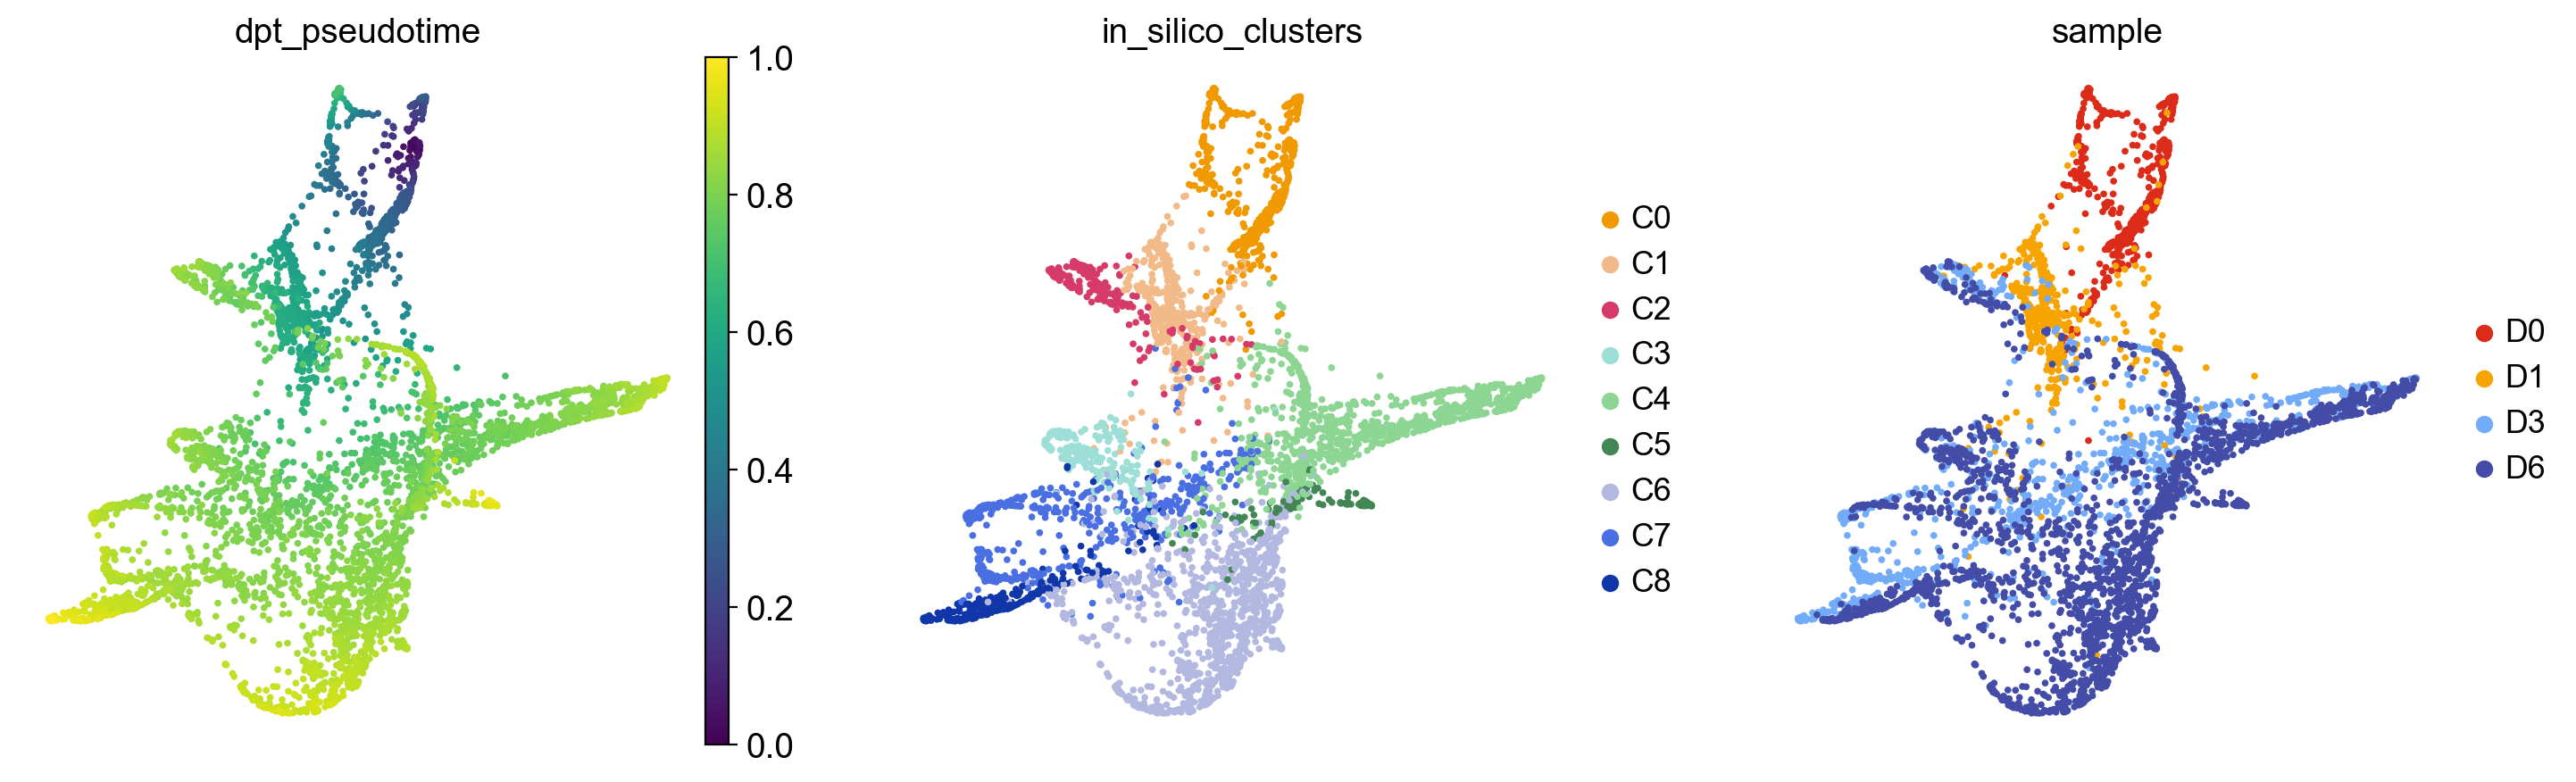

In [34]:
sc.pl.draw_graph(adata, color=['dpt_pseudotime', 'in_silico_clusters', 'sample'])

### Export diffusion pseudotime

In [35]:
out_dir = 'output/paga_diffmap10'
dpt = pd.DataFrame(adata.obs['dpt_pseudotime'])
dpt.to_csv(os.path.join(out_dir, 'dpt_pseudotime.csv'), index=True)